In [1]:
import warnings; warnings.filterwarnings("ignore", message="Initializing zero-element tensors is a no-op")
import pandas as pd
import torch
import os 
from utils.eval_utils import get_pairs, eval_epochs, LFWSingleDataset

from utils.utils import transform
from models.NN2 import FaceNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGES_PATH = './data/LFW/lfw-faces/'
DF_PATH = './data/LFW/'
EPOCHS_PATH = './checkpoints/'

In [2]:
test_df = pd.read_csv(os.path.join(DF_PATH, 'lfw_faces_test.csv'))
print(f'Test data shape: {test_df.shape}')

pairs = get_pairs(test_df, 1024)
print(f'Pairs shape: {pairs.shape}')

# Adiciona o path
pairs['img1'] = pairs['img1'].apply(lambda x: os.path.join(IMAGES_PATH, x))
pairs['img2'] = pairs['img2'].apply(lambda x: os.path.join(IMAGES_PATH, x))

Test data shape: (567, 2)
Pairs shape: (1024, 3)


In [3]:
pairs.head()

,img1,img2,label
0,./data/LFW/lfw-faces/Pierce_Brosnan_0012.jpg,./data/LFW/lfw-faces/Pierce_Brosnan_0004.jpg,1
1,./data/LFW/lfw-faces/Pierce_Brosnan_0012.jpg,./data/LFW/lfw-faces/David_Heymann_0005.jpg,0
2,./data/LFW/lfw-faces/Pierce_Brosnan_0009.jpg,./data/LFW/lfw-faces/Pierce_Brosnan_0014.jpg,1
3,./data/LFW/lfw-faces/Pierce_Brosnan_0009.jpg,./data/LFW/lfw-faces/John_Ashcroft_0043.jpg,0
4,./data/LFW/lfw-faces/Richard_Myers_0004.jpg,./data/LFW/lfw-faces/Richard_Myers_0008.jpg,1


# **VAL, FAR, ROC, Dists**

Calculating distances: 100%|██████████| 32/32 [00:03<00:00,  9.51it/s]


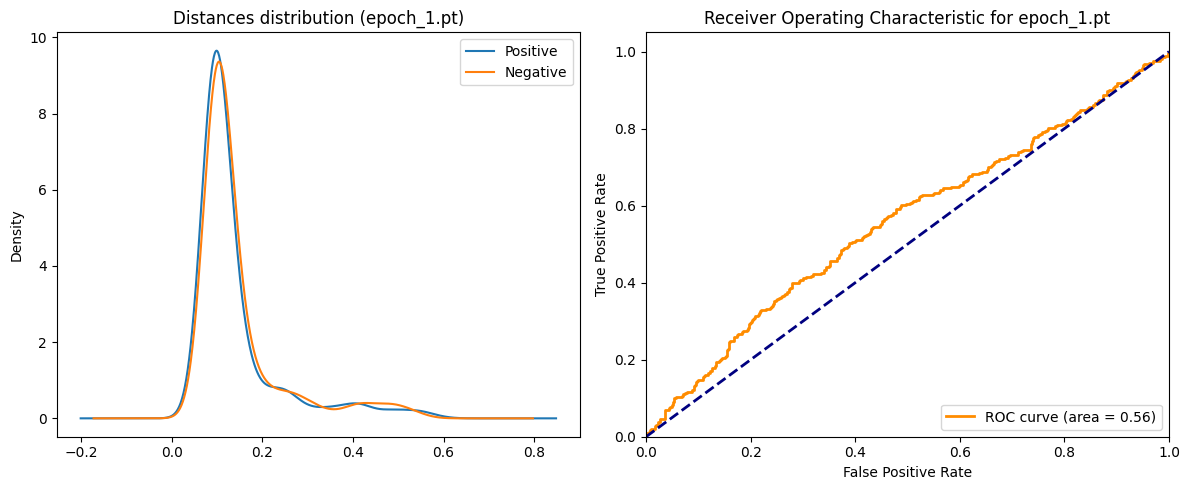

Target FAR: 1e-03 | Threshold: 0.0676
[epoch_1.pt] Accuracy: 0.5029
[epoch_1.pt] VAL: 0.0059

[epoch_1.pt] Positive mean: 0.1404 ± 0.0971
[epoch_1.pt] Negative mean: 0.1468 ± 0.0975


Calculating distances: 100%|██████████| 32/32 [00:03<00:00, 10.35it/s]


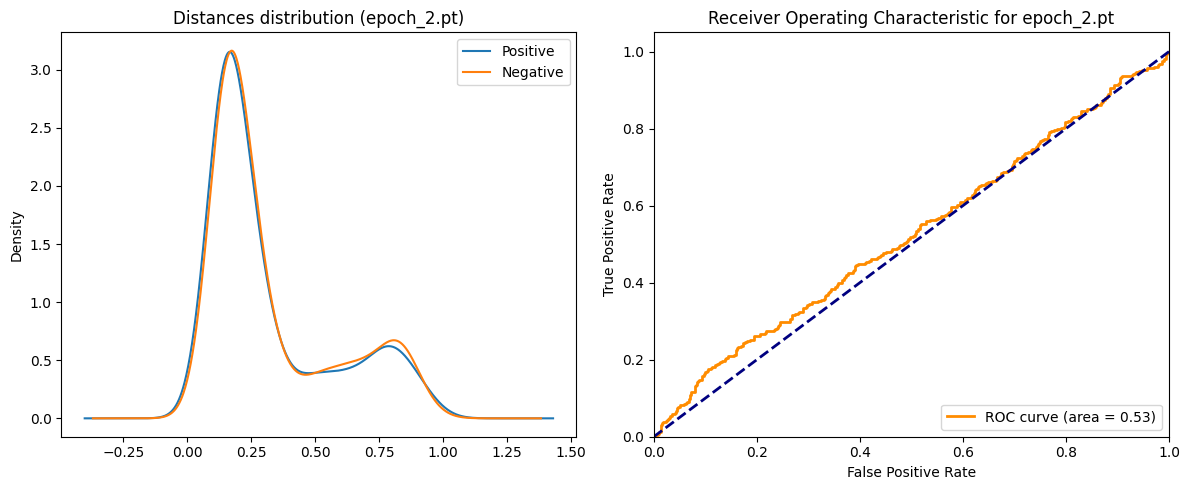

Target FAR: 1e-03 | Threshold: 0.0562
[epoch_2.pt] Accuracy: 0.5000
[epoch_2.pt] VAL: 0.0000

[epoch_2.pt] Positive mean: 0.3185 ± 0.2455
[epoch_2.pt] Negative mean: 0.3280 ± 0.2450


Calculating distances: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]


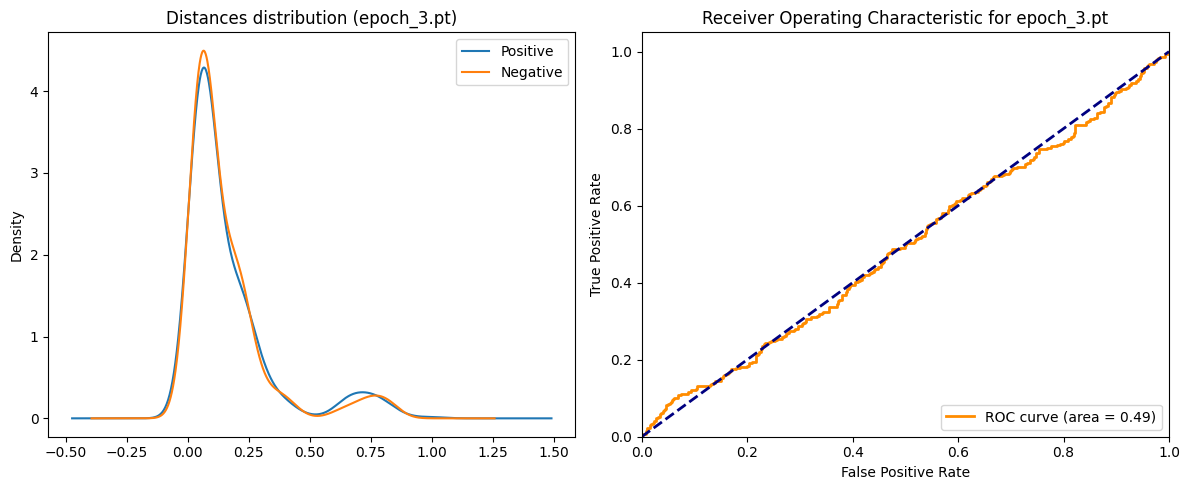

Target FAR: 1e-03 | Threshold: 0.0181
[epoch_3.pt] Accuracy: 0.5010
[epoch_3.pt] VAL: 0.0020

[epoch_3.pt] Positive mean: 0.1660 ± 0.1880
[epoch_3.pt] Negative mean: 0.1580 ± 0.1760


In [4]:
eval_epochs(epochs_path=EPOCHS_PATH, 
            pairs=pairs,
            model_class=FaceNet, 
            batch_size=32,
            transform=transform, 
            device=device,
            target_far=1e-3)

# **Visualizar os embeddings**

In [2]:
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def view_embs(epochs_path, model_class, test_df, transform, device):
    models_name = os.listdir(epochs_path)
    models_name = [model for model in models_name if 'bons' not in model]
    models_name_sorted = sorted(models_name, key=lambda x: int(x.replace('.pt', '').split('_')[1]))
    model = models_name_sorted[-1]
    
    modelo = model_class(emb_size=64).to(device)
    modelo.eval()

    test_dataset = LFWSingleDataset(test_df, transform=transform)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)

    model_path = os.path.join(epochs_path, model)
    load = torch.load(model_path)
    load = {k.replace('_orig_mod.', ''): v for k, v in load.items()}
    modelo.load_state_dict(load)
    
    embeddings = []
    with torch.no_grad():
        for (imgs, labels) in test_dataloader:
            images = imgs.to(device)
            embeddings.append(modelo(images).cpu().numpy())
    embeddings = np.concatenate(embeddings)
    
    # Reduzir dimensionalidade com t-SNE
    tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
    embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Reduzir dimensionalidade com PCA
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(24, 8))
    
    # Plotar t-SNE
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=test_df['id'], cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.title(f't-SNE {model}')
    
    # Plotar PCA
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=test_df['id'], cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.title(f'PCA {model}')
    
    plt.show()

view_embs(EPOCHS_PATH, FaceNet, test_df, transform, device)

FileNotFoundError: [Errno 2] No such file or directory: 'Mike_Myers_0002.jpg'